In [9]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import scipy.special
#plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import pymc as pm

# <font face="gotham" color="orange"> Generalized linear models </font>

The **generalized linear model** (GLM) is simply an umbrella term for all linear models which are not simple/multiple linear regression models, in econometrics we have seen logit, probit, tobit and etc., they are all generalized linear models.

As a reminder, the linear regression model's predicted values take the form
$$
\hat{Y}=X\beta
$$
To formulate a generalized linear model, we impose an arbitrary function onto the linear combination, i.e.
$$
\tilde{Y} = f(X\beta)
$$
where $f$ is called the **inverse link function**.

## <font face="gotham" color="orange"> Logistic Model with a Single Variable</font>

The most famous type of GLM is **logistic regression** which is also called _logit regression_ in the context of econometrics. Here we provide a brief refresh of logit regression.

A simple logit model hypothesizes a sigmoid shape function 
$$
P_i = \frac{1}{1+e^{-(\beta_1+\beta_2X_i)}}
$$
where the inverse link function is $\frac{1}{1+e^{-z}}$, and $z$ represents the predicted value of a linear model.

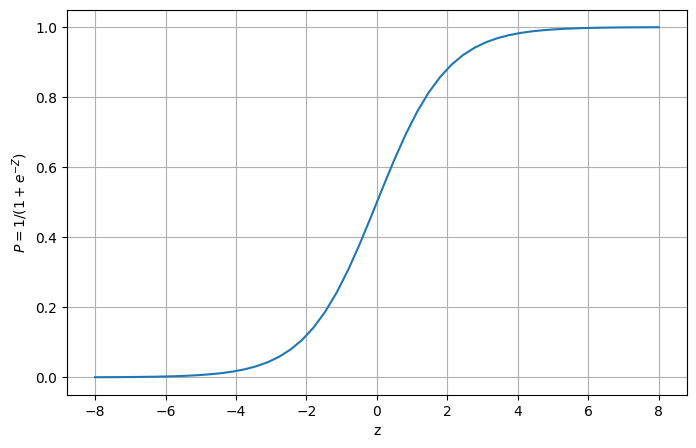

In [10]:
z = np.linspace(-8, 8)
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(z, 1 / (1 + np.exp(-z)))
ax.set_xlabel('z')
ax.set_ylabel(r'$P = 1/(1+e^{-Z})$')
ax.grid()
plt.show()

No matter what value we receive from $z$ (infinite domain), the final result will be transformed into a $[0, 1]$ range. The 

We usually denote $Z_i = \beta_1+\beta_2X_i$, ranges from $(-\infty, +\infty) $. This model solves the issues of probabilistic range and linear model. 

In order to estimate the logit model, we are seeking ways to linearize it. It might look confusing at first sight, here is the steps
$$
P_{i}=\frac{1}{1+e^{-Z_{i}}}=\frac{e^{Z_i}}{e^{Z_i}}\frac{1}{1+\frac{1}{e^{Z_i}}}=\frac{e^{Z_i}}{1+e^{Z_i}}
$$

And $1-P_i$
$$
1-P_{i}=\frac{1}{1+e^{Z_{i}}}
$$

Combine them, we have the odds ratios
$$
\frac{P_{i}}{1-P_{i}}=\frac{1+e^{Z_{i}}}{1+e^{-Z_{i}}}=e^{Z_{i}}
$$

Here's the interesting part, take natural log, we get a linearized model and we commonly call the log odds ratios the **logit**.
$$
\underbrace{\ln{\bigg(\frac{P_{i}}{1-P_{i}}\bigg)}}_{\text{logit}}= Z_i =\beta_1+\beta_2X_i
$$

To estimate the model, some technical procedures have to be carried out. Logit wouldn't have any meaningful interpretation, if we simply plug in the data $Y_i$. Because we don't observe $P_i$, the results are nonsensical.
$$
\ln \left(\frac{1}{0}\right) \quad \text{if a family own a house}\\
\ln \left(\frac{0}{1}\right) \quad \text{if a family does not own a house}
$$

One way to circumvent this technical issue, the data can be grouped to compute
$$
\hat{P}_{i}=\frac{n_{i}}{N_{i}}
$$
where $N_i$ is number of families in a certain income level, e.g. $[20000, 29999]$, and $n_i$ is the number of family owning a house in the that level.

However, this is not a preferred method, since we have nonlinear tools here. Recall that owning a house is following a Bernoulli distribution whose probability mass function is
$$
f_i(Y_i)= P_i^{Y_i}(1-P_i)^{1-Y_i}
$$
The joint distribution is the product of Bernoulli PMF due to their independence
$$
f\left(Y_{1}, Y_{2}, \ldots, Y_{n}\right)=\prod_{i=1}^{n} f_{i}\left(Y_{i}\right)=\prod_{i=1}^{n} P_{i}^{Y_{i}}\left(1-P_{i}\right)^{1-Y_{i}}
$$

In order to obtain log likelihood function, we take natural log
$$
\begin{aligned}
\ln f\left(Y_{1}, Y_{2}, \ldots, Y_{n}\right) &=\sum_{i=1}^{n}\left[Y_{i} \ln P_{i}+\left(1-Y_{i}\right) \ln \left(1-P_{i}\right)\right] \\
&=\sum_{i=1}^{n}\left[Y_{i} \ln P_{i}-Y_{i} \ln \left(1-P_{i}\right)+\ln \left(1-P_{i}\right)\right] \\
&=\sum_{i=1}^{n}\left[Y_{i} \ln \left(\frac{P_{i}}{1-P_{i}}\right)\right]+\sum_{i=1}^{n} \ln \left(1-P_{i}\right)
\end{aligned}
$$
Replace 
$$
\ln{\bigg(\frac{P_{i}}{1-P_{i}}\bigg)}=\beta_1+\beta_2X_i\\
1-P_{i}=\frac{1}{1+e^{\beta_1+\beta_2X_i}}
$$

Finally we have log likelihood function of $\beta$
$$
\ln f\left(Y_{1}, Y_{2}, \ldots, Y_{n}\right)=\sum_{i=1}^{n} Y_{i}\left(\beta_{1}+\beta_{2} X_{i}\right)-\sum_{i=1}^{n} \ln \left[1+e^{\left(\beta_{1}+\beta_{2} X_{i}\right)}\right]
$$
Take partial derivative w.r.t to $\beta_2$
$$
\frac{\partial LF}{\partial \beta_2} = n\beta_2 -\sum_{i=1}^n\frac{e^{\beta_1+\beta_2X_i}X_i}{1+e^{\beta_1+\beta_2X_i}}=0
$$
And stop here, apparently there won't be analytical solutions, i.e. numerical solutions are necessary. And this is exactly what Python is doing for us below.

### <font face="gotham" color="orange"> Apartment Price Example</font>

Here we come back to the apartment owning example. The data is an excerpt of survey of citizens in Manchester, UK.

In [11]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'HouseOwn_Quali_Resp'); df.head()

Y = df[['Own_House']]
X = df[['Annual_Family_Income']]
X = sm.add_constant(X)

log_reg = sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.257124
         Iterations 8


Optimization of likelihood function is an iterative process and global optimization has been reached as the notice shows. 

Print the estimation results.

In [12]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Own_House   No. Observations:                   38
Model:                          Logit   Df Residuals:                       36
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                  0.6261
Time:                        14:02:23   Log-Likelihood:                -9.7707
converged:                       True   LL-Null:                       -26.129
Covariance Type:            nonrobust   LLR p-value:                 1.067e-08
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.7617      2.189     -3.088      0.002     -11.053      -2.471
Annual_Family_Income     0.1678      0.053      3.176      0.001       0.064       0.271


Here is the estimated model
$$
\hat{P_i} = \frac{1}{1+e^{6.7617-0.1678 X_i}}
$$
And the fitted curve

C:\Users\user\AppData\Local\Temp\ipykernel_4448\2784342192.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  P_hat = 1/(1 + np.exp(-log_reg.params[0]-log_reg.params[1]*X))


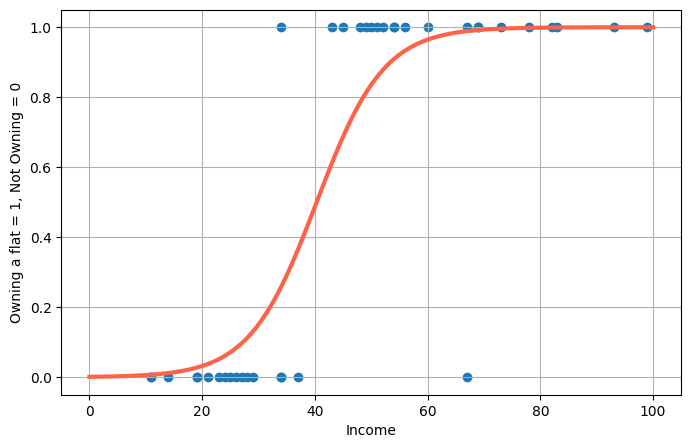

In [13]:
X = np.linspace(0, 100, 500)
P_hat = 1/(1 + np.exp(-log_reg.params[0]-log_reg.params[1]*X))

fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(df['Annual_Family_Income'], df['Own_House'])
ax.plot(X, P_hat, color = 'tomato', lw = 3)
ax.set_xlabel('Income')
ax.set_ylabel('Owning a flat = 1, Not Owning = 0')
ax.grid()
plt.show()

To interpret estimated coefficients, we can calculate the marginal effect by taking derivative w.r.t certain $\beta$, in this case $\beta_2$.
$$
\frac{dP_i}{d X_i} = \frac{dP_i}{dZ_i}\frac{dZ_i}{dX_i}=\frac{e^{-Z_i}}{(1+e^{-Z_i})^2}\beta_2
$$
Plot both accumulative and marginal effects

C:\Users\user\AppData\Local\Temp\ipykernel_4448\2635668883.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta1_hat, beta2_hat = log_reg.params[0], log_reg.params[1]


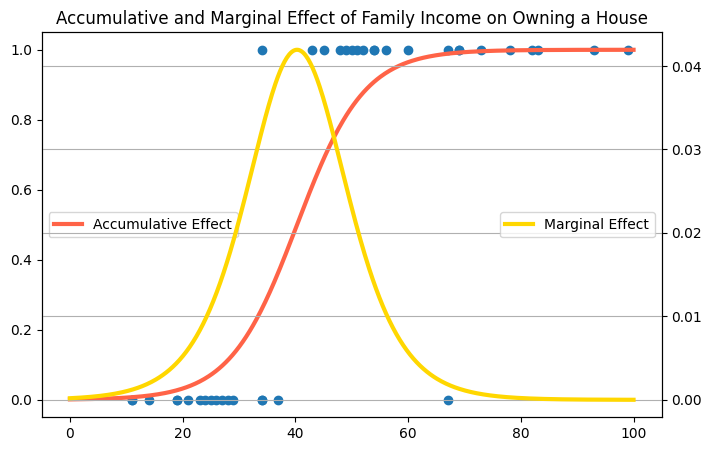

In [14]:
beta1_hat, beta2_hat = log_reg.params[0], log_reg.params[1]
X = np.linspace(0, 100, 500)

Z = beta1_hat + beta2_hat*X
dPdX = np.exp(-Z)/(1+np.exp(-Z))**2*beta2_hat

fig, ax1 = plt.subplots(figsize = (8, 5))
ax1.scatter(df['Annual_Family_Income'], df['Own_House'])
ax1.plot(X, P_hat, color = 'tomato', lw = 3, label='Accumulative Effect')
ax1.legend(loc ='center left')

ax2 = ax1.twinx() 
ax2.plot(X, dPdX, lw = 3, color = 'Gold', label = 'Marginal Effect')
ax2.legend(loc='center right')
ax2.set_title('Accumulative and Marginal Effect of Family Income on Owning a House')
ax2.grid()
plt.show()

As family income raises, the marginal probability will reach maximum around $40000$ pounds, to summarize the effect, we calculate the marginal effect at the mean value of the independent variables. 

In [15]:
X_mean = np.mean(df['Annual_Family_Income'])
Z_mean_effect = beta1_hat + beta2_hat*X_mean
dPdX = np.exp(-Z_mean_effect)/(1+np.exp(-Z_mean_effect))**2*beta2_hat; dPdX

0.03297676614392625

At the sample mean, $1000$ pounds increase in family income increases the probability of owning a house by $3.2 \%$. 

In [16]:
with pm.Model() as model_0:
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    
    mu = beta1 + beta2*df['Annual_Family_Income']   
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -beta1/beta2)
    
    yl = pm.Bernoulli('yl', p=theta, observed=df['Own_House'])

    trace_0 = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pytensor\scalar\basic.py:2004: RuntimeWarning: invalid value encountered in divide
  return x / y
c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pytensor\scalar\basic.py:2004: RuntimeWarning: invalid value encountered in divide
  return x / y
c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\pypoet

Output()